# **Trabajo en clase**

## **Semana 11**

----------------------------------------------------------------------------------------------------------------

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import copy
import numpy as np
from scipy.integrate import trapz, simps
import math
import random
%matplotlib inline

In [8]:
from colossus.cosmology import cosmology

In [10]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


Cargamos los datos:

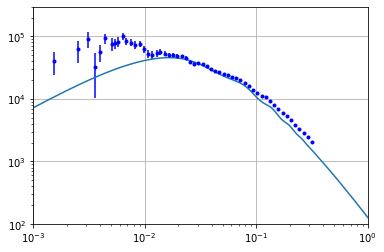

In [11]:
k = 10**np.linspace(-5,6,100000)
Pk = cosmo.matterPowerSpectrum(k,0.57)

pk_cmasdr12 = np.loadtxt('GilMarin_2016_CMASSDR12_measurement_monopole_post_recon.txt').T
plt.figure()
plt.loglog()
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt = '.b')
plt.plot(k, 1.85**2*Pk, '-')
plt.xlim(1e-3,1)
plt.ylim(100, 3e5)
plt.grid('True')

Tenemos un nuevo parámetro $\beta$:
$P(k) = b^2(1+\beta)Pl(k)$

In [14]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

def Pk_Om(Om_,b,beta,k):
    cosmo = cosmology.setCosmology('planck15') # Generamos los parámetros default del experimento planck15
    z = 0.57 
    cosmo.Om0 = Om_ # Modificamos la densidad de materia
    return b**2*(1+beta)*cosmo.matterPowerSpectrum(k,z) # Se regresa la función matterPowerSpectrum multiplicada por el bias al cuadrado

def likelihood(Om, b, beta,data): # Función que calcula el logaritmo natural del likelihood
    equis = data[0] # Llamamos x al primer conjunto de datos
    ye = data[1] # Llamamos y al segundo conjunto de datos
    yerr = data[2]  # Llamamos yerror al tercer conjunto de datos
    model = Pk_Om(Om, b, beta,equis) # Calculamos el modelo utilizando la función Pk_om
    likelihood_0 = (ye-model)**2/(yerr**2)  # Obtenemos chi^2
    return likelihood_0.sum() # Regresamos la suma de todos los chi^2, que da como resultado el ln del likelihood.

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [23]:
np.random.seed(1) # Semilla para los números aleatorios.
x = pk_cmasdr12[0][15:45] # Quitamos los datos del inicio que no se ajustan a ningún modelo del matterPowerSpectrum
y = pk_cmasdr12[1][15:45]
yerror = pk_cmasdr12[2][15:45]

rango = 500 # Establecemos un rango de 2000

Om_0 = 0.4 # Damos un valor inicial para la densidad de materia
b0 = 2.2 # Valor inicial para el bias
beta0 = 0.7 # Valor inicial para beta
lnlike0 = -1*likelihood(Om_0, b0, beta0,[x,y,yerror]) # Calculamos el logaritmo natural del primer likelihood 

Om_sample = [Om_0] # Guardamos el primer valor de la densidad de mateira
b_sample = [b0] # Guardamos el primer valor del bias
beta_sample = [beta0]

sigma = 0.01 # Establecemos un valor para la desviación estándar de los caminos en el método de metrópolis

for j in range(1,rango):
    Om_new = np.random.normal(Om_sample[len(Om_sample)-1], sigma) # Generamos un valor de densidad de materia nuevo de una probabilidad gaussiana con mediana igual al valor anterior de Om0 y con desviación estándar sigma.
    b_new = np.random.normal(b_sample[len(b_sample)-1], sigma)
    beta_new = np.random.normal(beta_sample[len(b_sample)-1], sigma)
    if Om_new <= 0.5 and Om_new >= 0.1 and b_new <= 3 and b_new >= 1 and beta_new >=0 and beta_new <=1: # Establecemos el prior
        like = -1*likelihood(Om_new, b_new, beta_new,[x,y,yerror])
        if like>lnlike0: # Si el logaritmo natural del nuevo likelihood es mayor que el anterior, se acepta
            lnlike0 = like
            Om_sample.append(Om_new) # Se guardan los nuevos valores de Om0, b y beta
            b_sample.append(b_new)
            beta_sample.append(beta_new)
        elif lnlike0-like<-1*math.log(random.uniform(0,1)): # Si la diferencia es menor que el negativo del logaritmo de un número aletorio de una distribución uniforme, se acepta.
            lnlike0 = like
            Om_sample.append(Om_new) # Se guardan los nuevos valores de Om0, b y beta
            b_sample.append(b_new)
            beta_sample.append(beta_new)

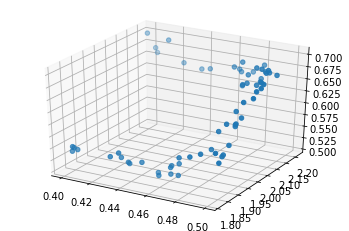

In [24]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax1 = fig.add_subplot(111,projection='3d')

ax1.scatter(Om_sample, b_sample, beta_sample)

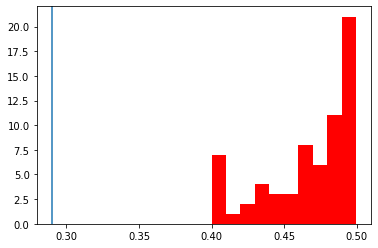

In [25]:
plt.hist(Om_sample, color = 'red')
plt.axvline(0.29)

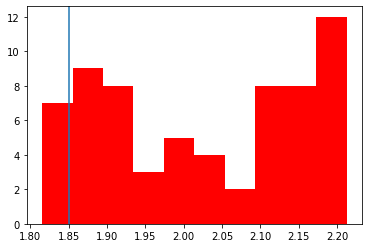

In [26]:
plt.hist(b_sample, color = 'red')
plt.axvline(1.85)

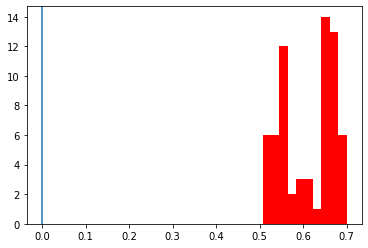

In [27]:
plt.hist(beta_sample, color = 'red')
plt.axvline(0)

**Ahora utilizamos varios caminos:**

In [28]:
np.random.seed(1) # Semilla para los números aleatorios.
x = pk_cmasdr12[0][15:45] # Quitamos los datos del inicio que no se ajustan a ningún modelo del matterPowerSpectrum
y = pk_cmasdr12[1][15:45]
yerror = pk_cmasdr12[2][15:45]

Om_total = [] # Declaramos Om_total, que es donde se guardarán los valores de Om0 para cada camino
b_total = [] # Lo mismo para el bias. 
beta_total = []

sigma = 0.01 # Desviación estándar de la distribución gaussiana de números aleatorios.
rango = 1000

for k in range(5): # 10 caminos
    Om_0 = np.random.uniform(0.1, 0.7, 10) # Los valores iniciales para cada camino se generarán con números aleatorios de una distribución uniforme
    b0 = np.random.uniform(1, 3, 10) # Lo mismo para el bias
    beta0 = np.random.uniform(0, 1, 10) # Lo mismo para beta
    Om_sample = [Om_0[k]] # Guardamos el valor inicial para Om0 del camino k
    b_sample = [b0[k]] # Guardamos el valor inicial para el bias del camino k
    beta_sample = [beta0[k]] # Guardamos el valor inicial para el Beta del camino k
    lnlike0 = -1*likelihood(Om_0[k], b0[k], beta0[k],[x,y,yerror]) # Calculamos el logaritmo natural del likelihood inicial para cada camino
    for j in range(1,rango):
        Om_new = np.random.normal(Om_sample[len(Om_sample)-1], sigma) # Obtenemos un nuevo valor para Om0
        b_new = np.random.normal(b_sample[len(b_sample)-1], sigma) # Obtenemos un nuevo valor para b
        beta_new = np.random.normal(beta_sample[len(beta_sample)-1], sigma) # Obtenemos un nuevo valor para beta
        if Om_new <= 0.7 and Om_new >= 0.1 and b_new <= 3 and b_new >= 1 and beta_new >= 0 and beta_new <=1: # Prior
            like = -1*likelihood(Om_new, b_new, beta_new,[x,y,yerror]) # Prior
            if like>lnlike0: # Si el nuevo ln de L es mayor que el anterior, se acepta
                lnlike0 = like
                Om_sample.append(Om_new) # Se guarda el nuevo valor de Om0 para el camino k
                b_sample.append(b_new) # Lo mismo para b
                beta_sample.append(beta_new)
            elif lnlike0-like<-math.log(random.uniform(0,1)): # Si la diferencia es menor que el logaritmo de un número aleatorio en 0 y 1 se acepta
                lnlike0 = like 
                Om_sample.append(Om_new) # Se guarda el nuevo valor de Om0 para el camino k
                b_sample.append(b_new) # Lo mismo para b
                beta_sample.append(beta_new)
    Om_total.append(Om_sample) # Se guardan los valores de Om0 del camino k en m_total
    b_total.append(b_sample)
    beta_total.append(beta_sample)

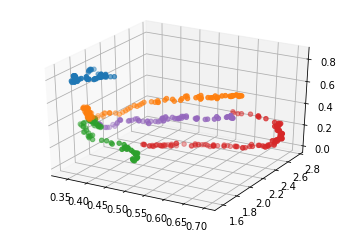

In [29]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax1 = fig.add_subplot(111,projection='3d')

for i in range(len(Om_total)):
    ax1.scatter(Om_total[i], b_total[i], beta_total[i])

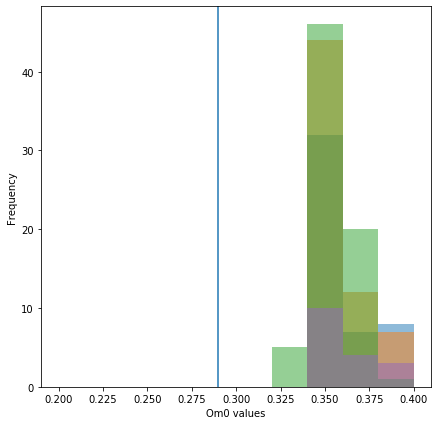

In [31]:
plt.figure(figsize = (7,7))
for i in range(len(Om_total)):
    plt.hist(Om_total[i], range = (0.2,0.4),alpha = 0.5)

plt.axvline(0.29)
plt.xlabel('Om0 values')
plt.ylabel('Frequency');

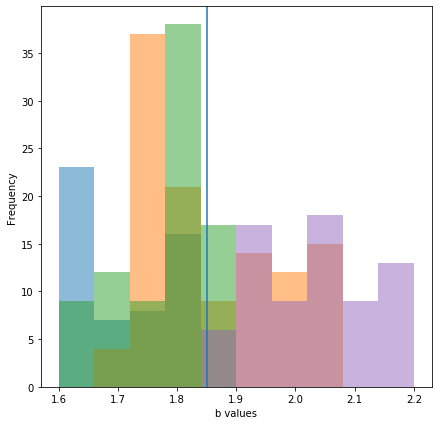

In [32]:
plt.figure(figsize = (7,7))
for i in range(len(Om_total)):
    plt.hist(b_total[i], range = (1.6,2.2) ,alpha = 0.5)

plt.axvline(1.85)
plt.xlabel('b values')
plt.ylabel('Frequency');

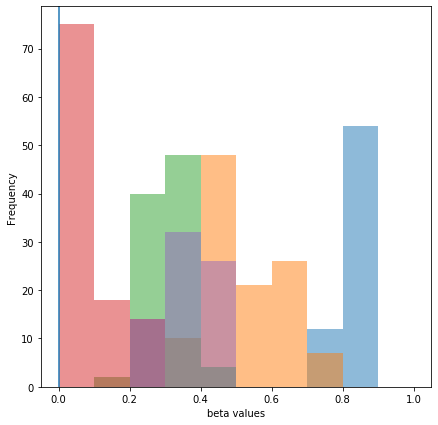

In [34]:
plt.figure(figsize = (7,7))
for i in range(len(beta_total)):
    plt.hist(beta_total[i], range = (0.0,1.0) ,alpha = 0.5)

plt.axvline(0)
plt.xlabel('beta values')
plt.ylabel('Frequency');

Quitamos el burning:

In [38]:
Om_new = []
b_new = []
beta_new = []

burn = 50
for i in range(len(Om_total)):
    if(len(Om_total[i])>burn and len(b_total[i])>burn and len(beta_total[i])):
        Om_new.append(Om_total[i][burn:])
        b_new.append(b_total[i][burn:])
        beta_new.append(beta_total[i][burn:])

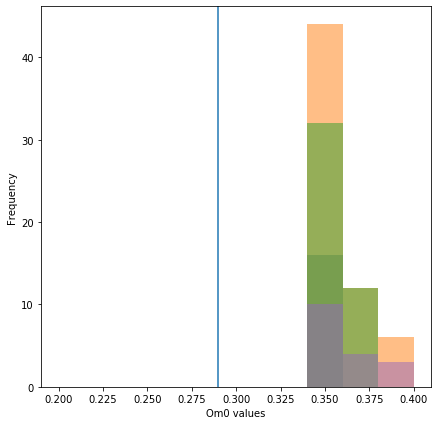

In [39]:
plt.figure(figsize = (7,7))
for i in range(len(Om_new)):
    plt.hist(Om_new[i], range = (0.2,0.4),alpha = 0.5)

plt.axvline(0.29)
plt.xlabel('Om0 values')
plt.ylabel('Frequency');

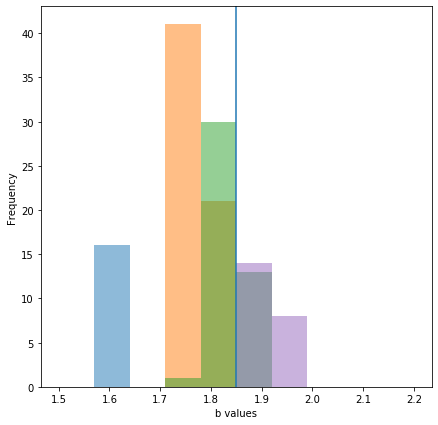

In [40]:
plt.figure(figsize = (7,7))
for i in range(len(b_new)):
    plt.hist(b_new[i], range = (1.5,2.2),alpha = 0.5)

plt.axvline(1.85)
plt.xlabel('b values')
plt.ylabel('Frequency');

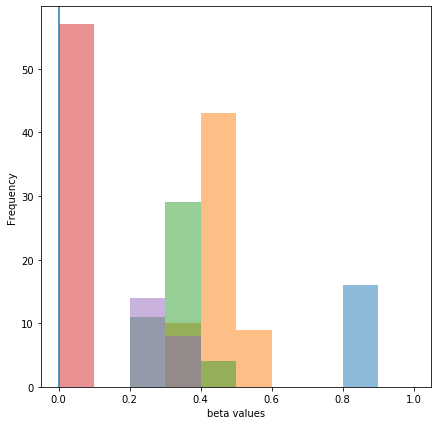

In [47]:
plt.figure(figsize = (7,7))
for i in range(len(beta_new)):
    plt.hist(beta_new[i], range = (0.0,1.0),alpha = 0.5)

plt.axvline(0)
plt.xlabel('beta values')
plt.ylabel('Frequency');

**Calculamos las medianas**

In [52]:
from statistics import median

In [48]:
mediana0 = []

for i in range(len(Om_new)):
    mediana0.append(np.median(Om_new[i]))

In [49]:
medianab = []

for i in range(len(b_new)):
    medianab.append(np.median(b_new[i]))

In [50]:
medianabeta = []

for i in range(len(beta_new)):
    medianabeta.append(np.median(beta_new[i]))

In [53]:
Om0 = median(mediana0)
be = median(medianab)
beta = median(medianabeta)
print(Om0, be, beta)

0.35881185343867283 1.818471393709637 0.3519866180790424


**Finalmente graficamos y vemos qué tan bien nuestro modelo se ajusta a los datos**

Text(0, 0.5, 'P(k)')

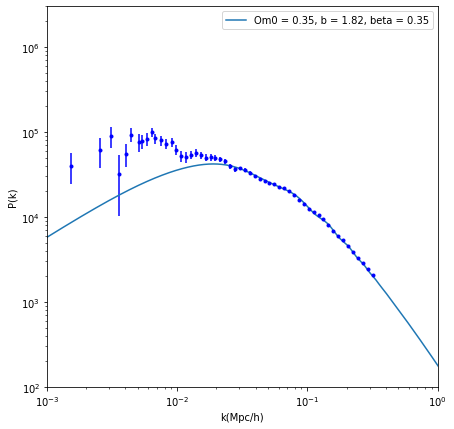

In [55]:
plt.figure(figsize = (7,7))
plt.loglog()

k = 10**np.linspace(-5,6,100000)
cosmo.Om0 = Om0
Pk = be**2*(1+beta)*cosmo.matterPowerSpectrum(k,0.57)

plt.plot(k,Pk, '-', label = 'Om0 = 0.35, b = 1.82, beta = 0.35') # Con bias
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt = '.b')
  
plt.xlim(1e-3,1)
plt.ylim(100,3e6)
plt.legend()
plt.xlabel('k(Mpc/h)')
plt.ylabel('P(k)')

**Ahora intentaremos ajustar utilizando el siguiente modelo:** 
$P(k) = b^2(1+\frac{\Omega^{0.55}_{m,0}}{b})P_L(k, \Omega_{m,0})$

In [56]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

def Pk_Om(Om_,b,k):
    cosmo = cosmology.setCosmology('planck15') # Generamos los parámetros default del experimento planck15
    z = 0.57 
    cosmo.Om0 = Om_ # Modificamos la densidad de materia
    return b**2*(1+(Om_**0.55/b))*cosmo.matterPowerSpectrum(k,z) # Se regresa la función matterPowerSpectrum multiplicada por el bias al cuadrado

def likelihood(Om, b, data): # Función que calcula el logaritmo natural del likelihood
    equis = data[0] # Llamamos x al primer conjunto de datos
    ye = data[1] # Llamamos y al segundo conjunto de datos
    yerr = data[2]  # Llamamos yerror al tercer conjunto de datos
    model = Pk_Om(Om, b, equis) # Calculamos el modelo utilizando la función Pk_om
    likelihood_0 = (ye-model)**2/(yerr**2)  # Obtenemos chi^2
    return likelihood_0.sum() # Regresamos la suma de todos los chi^2, que da como resultado el ln del likelihood.

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [ ]:
np.random.seed(1) # Semilla para los números aleatorios.
x = pk_cmasdr12[0][15:45] # Quitamos los datos del inicio que no se ajustan a ningún modelo del matterPowerSpectrum
y = pk_cmasdr12[1][15:45]
yerror = pk_cmasdr12[2][15:45]

rango = 2000 # Establecemos un rango de 2000

Om_0 = 0.4 # Damos un valor inicial para la densidad de materia
b0 = 2.2 # Valor inicial para el bias
lnlike0 = -1*likelihood(Om_0, b0, [x,y,yerror]) # Calculamos el logaritmo natural del primer likelihood 

Om_sample = [Om_0] # Guardamos el primer valor de la densidad de mateira
b_sample = [b0] # Guardamos el primer valor del bias

sigma = 0.01 # Establecemos un valor para la desviación estándar de los caminos en el método de metrópolis

for j in range(1,rango):
    Om_new = np.random.normal(Om_sample[len(Om_sample)-1], sigma) # Generamos un valor de densidad de materia nuevo de una probabilidad gaussiana con mediana igual al valor anterior de Om0 y con desviación estándar sigma.
    b_new = np.random.normal(b_sample[len(b_sample)-1], sigma)
    if Om_new <= 0.5 and Om_new >= 0.1 and b_new <= 3 and b_new >= 1: # Establecemos el prior
        like = -1*likelihood(Om_new, b_new, [x,y,yerror])
        if like>lnlike0: # Si el logaritmo natural del nuevo likelihood es mayor que el anterior, se acepta
            lnlike0 = like
            Om_sample.append(Om_new) # Se guardan los nuevos valores de Om0 y b
            b_sample.append(b_new)
        elif lnlike0-like<-1*math.log(random.uniform(0,1)): # Si la diferencia es menor que el negativo del logaritmo de un número aletorio de una distribución uniforme, se acepta.
            lnlike0 = like
            Om_sample.append(Om_new) # Se guardan los nuevos valores de Om0 y b
            b_sample.append(b_new)